In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.integrate as integrate
from tqdm import tqdm
import statistics
import corner

In [285]:
data_dl_old = np.array([  40.53806137,   62.07017585,   61.0243238 , 69.31112943,
         86.25076898,  101.13069126,  116.81617341,  146.8192414 ,
        170.23269545,  201.3738048 ,  222.4861474 ,  280.98489615,
        318.50992938,  405.88497578,  465.31063183,  549.11458077,
        677.11584355,  768.00310486,  945.15486863, 1117.84857053,
       1349.22063847, 1578.1307268 , 2001.53401815, 2372.8100645 ,
       2906.58465084, 3471.22668519, 4242.51098787, 5223.03547744,
       6480.41734566, 8315.77970426, 9582.15023658])

In [286]:
data_dl = data_dl_old * 67.3 / 73

In [287]:
delta_dl = np.array([  2.72346151,   4.79634547,   2.20603503,   2.30946165,
         3.39449223,   2.61388012,   3.28521861,   3.83796674,
         4.45249119,   6.96847286,   9.51854653,   8.03423717,
         9.66313141,  10.21509654,  12.84279292,   9.4662071 ,
        12.04078295,  12.26860817,  13.98936404,  16.96826551,
        19.70873491,  28.53401192,  30.94814492,  45.37042514,
        52.69970136,  57.46065654, 122.65212034, 131.30859924,
       199.43646926, 592.06360303, 610.95412592])

In [288]:
data_z = np.array([0.01 , 0.012, 0.014, 0.016, 0.019, 0.023, 0.026, 0.031, 0.037,
       0.043, 0.051, 0.06 , 0.07 , 0.082, 0.097, 0.114, 0.134, 0.158,
       0.186, 0.218, 0.257, 0.302, 0.355, 0.418, 0.491, 0.578, 0.679,
       0.799, 0.94 , 1.105, 1.3  ])

Text(0.5, 0, '$z$')

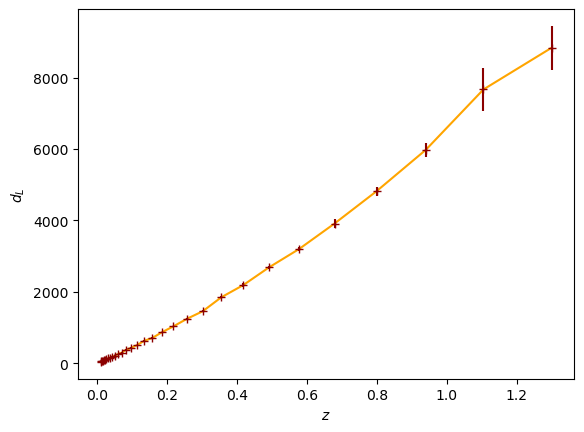

In [289]:
plt.plot(data_z,data_dl, color="orange")
plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ="+", color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

In [290]:
def llike(data_dl, data_z, H0_prop, q0_prop, j0_prop, delta_dl, N_obs):
    
    c = 3e5
    model_dl = ((c*data_z)/H0_prop)*(1+0.5*(1-q0_prop)*data_z-(1/6)*(1-q0_prop-3*q0_prop**2+j0_prop)*data_z**2)
    
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - model_dl)**2)
                          
    return(first_term + second_term)

In [291]:
def lprior_uniform(param, param_low_val, param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

In [292]:
def lpost(data_dl, data_z, H0_prop, q0_prop, j0_prop, delta_dl, N_obs, param1, param2, param3,
          param1_low_range = 30, param1_high_range = 100, 
          param2_low_range = -10, param2_high_range = 10,
          param3_low_range = -10, param3_high_range = 10):
    """
    Compute log posterior - require log likelihood and log prior.
    """
    return(lprior_uniform(param1, param1_low_range, param1_high_range) 
           +lprior_uniform(param2, param2_low_range, param2_high_range)
           +lprior_uniform(param3, param3_low_range, param3_high_range)
           + llike(data_dl, data_z, H0_prop, q0_prop, j0_prop, delta_dl, N_obs))

In [293]:
def accept_reject(lp_prop, lp_prev):
    """
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    """
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

In [294]:
def MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs, param_start, H0_var_prop, q0_var_prop, j0_var_prop, printerval):
    """
    Metropolis MCMC sampler
    """

    # Set starting values

    H0_chain = [param_start[0]]
    q0_chain = [param_start[1]]
    j0_chain = [param_start[2]]
                                           
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_dl, data_z, H0_chain[0], q0_chain[0], j0_chain[0], delta_dl, N_obs, H0_chain[0], q0_chain[0], j0_chain[0])) # Append first value of log posterior 
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        
        if i % printerval == 0: # Print accept/reject ratio.
            # tqdm.write("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            accept_reject_ratio = sum(accept_reject_count)/len(accept_reject_count)
            tqdm.write("Iteration {0}, accept_reject = {1}".format(i,accept_reject_ratio))
            # print("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 

        H0_prop = np.random.normal(H0_chain[i - 1], np.sqrt(H0_var_prop))
        q0_prop = np.random.normal(q0_chain[i - 1], np.sqrt(q0_var_prop))
        j0_prop = np.random.normal(j0_chain[i - 1], np.sqrt(j0_var_prop))
    
        # Compute log posterior
        lp_prop = lpost(data_dl, data_z, H0_prop, q0_prop, j0_prop, delta_dl, N_obs, H0_prop, q0_prop, j0_prop)
        
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            H0_chain.append(H0_prop)    # accept H0_{prop} as new sample
            q0_chain.append(q0_prop)      # accept q0_{prop} as new sample
            j0_chain.append(j0_prop)    # accept j0_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
            
        else:  # Reject, if this is the case we use previously accepted values
            H0_chain.append(H0_chain[i - 1])
            q0_chain.append(q0_chain[i - 1])
            j0_chain.append(j0_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as np.arrays

    H0_chain = np.array(H0_chain)
    q0_chain = np.array(q0_chain)
    j0_chain = np.array(j0_chain)
    
    H0_chain = H0_chain[burnin:]
    q0_chain = q0_chain[burnin:]
    j0_chain = j0_chain[burnin:]
    
    return H0_chain, q0_chain, j0_chain, lp  # Return chains and log posterior.

In [295]:
param_start = [60, -2, 5]

Ntotal = 300000 # Total number of iterations
burnin = 70000  # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters
H0_var_prop = 0.01
q0_var_prop = 0.01
j0_var_prop = 0.01
printerval = 5000

N_obs = len(data_z)

In [296]:
H0_chain, q0_chain, j0_chain, lp = MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs,
                                           param_start, H0_var_prop, q0_var_prop, j0_var_prop, printerval)

  4%|█████▊                                                                                                                                                       | 11212/299999 [00:00<00:07, 38837.25it/s]

Iteration 5000, accept_reject = 0.3106
Iteration 10000, accept_reject = 0.3028


  8%|████████████▋                                                                                                                                                | 24153/299999 [00:00<00:06, 42014.37it/s]

Iteration 15000, accept_reject = 0.29733333333333334
Iteration 20000, accept_reject = 0.29535


 11%|█████████████████▏                                                                                                                                           | 32724/299999 [00:00<00:06, 42543.30it/s]

Iteration 25000, accept_reject = 0.29152
Iteration 30000, accept_reject = 0.29023333333333334


 14%|█████████████████████▋                                                                                                                                       | 41478/299999 [00:01<00:05, 43217.80it/s]

Iteration 35000, accept_reject = 0.2902571428571429
Iteration 40000, accept_reject = 0.29115


 18%|████████████████████████████▋                                                                                                                                | 54760/299999 [00:01<00:05, 43970.16it/s]

Iteration 45000, accept_reject = 0.2931111111111111
Iteration 50000, accept_reject = 0.29294


 21%|█████████████████████████████████▎                                                                                                                           | 63578/299999 [00:01<00:05, 44019.93it/s]

Iteration 55000, accept_reject = 0.2908545454545455
Iteration 60000, accept_reject = 0.29108333333333336


 24%|█████████████████████████████████████▉                                                                                                                       | 72408/299999 [00:01<00:05, 44079.49it/s]

Iteration 65000, accept_reject = 0.29035384615384613
Iteration 70000, accept_reject = 0.2865857142857143


 27%|██████████████████████████████████████████▌                                                                                                                  | 81218/299999 [00:01<00:04, 43973.66it/s]

Iteration 75000, accept_reject = 0.28561333333333333
Iteration 80000, accept_reject = 0.2866375


 31%|█████████████████████████████████████████████████▍                                                                                                           | 94482/299999 [00:02<00:04, 44102.01it/s]

Iteration 85000, accept_reject = 0.2858470588235294
Iteration 90000, accept_reject = 0.28517777777777775


 34%|█████████████████████████████████████████████████████▋                                                                                                      | 103277/299999 [00:02<00:04, 43673.76it/s]

Iteration 95000, accept_reject = 0.28476842105263156
Iteration 100000, accept_reject = 0.28499


 37%|██████████████████████████████████████████████████████████▏                                                                                                 | 112012/299999 [00:02<00:04, 43575.83it/s]

Iteration 105000, accept_reject = 0.28482857142857143
Iteration 110000, accept_reject = 0.2837181818181818


 40%|██████████████████████████████████████████████████████████████▊                                                                                             | 120745/299999 [00:02<00:04, 43605.12it/s]

Iteration 115000, accept_reject = 0.28420869565217394
Iteration 120000, accept_reject = 0.2838


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                      | 134038/299999 [00:03<00:03, 44058.58it/s]

Iteration 125000, accept_reject = 0.284872
Iteration 130000, accept_reject = 0.28536923076923076


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                 | 142809/299999 [00:03<00:03, 43441.07it/s]

Iteration 135000, accept_reject = 0.2857037037037037
Iteration 140000, accept_reject = 0.2844714285714286


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                             | 151495/299999 [00:03<00:03, 43377.04it/s]

Iteration 145000, accept_reject = 0.28460689655172416
Iteration 150000, accept_reject = 0.2839933333333333


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 164667/299999 [00:03<00:03, 43788.45it/s]

Iteration 155000, accept_reject = 0.28398064516129035
Iteration 160000, accept_reject = 0.28444375


 58%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 173445/299999 [00:04<00:02, 43664.49it/s]

Iteration 165000, accept_reject = 0.2847030303030303
Iteration 170000, accept_reject = 0.28511176470588234


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 182167/299999 [00:04<00:02, 43431.28it/s]

Iteration 175000, accept_reject = 0.28521142857142856
Iteration 180000, accept_reject = 0.2850722222222222


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 190869/299999 [00:04<00:02, 43470.92it/s]

Iteration 185000, accept_reject = 0.28585945945945945
Iteration 190000, accept_reject = 0.2858842105263158


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 203955/299999 [00:04<00:02, 43549.83it/s]

Iteration 195000, accept_reject = 0.2858
Iteration 200000, accept_reject = 0.285645


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 212699/299999 [00:04<00:02, 43148.16it/s]

Iteration 205000, accept_reject = 0.28565365853658536
Iteration 210000, accept_reject = 0.28536666666666666


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 221366/299999 [00:05<00:01, 42972.92it/s]

Iteration 215000, accept_reject = 0.2856511627906977
Iteration 220000, accept_reject = 0.2861818181818182


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 234275/299999 [00:05<00:01, 42643.58it/s]

Iteration 225000, accept_reject = 0.28598222222222225
Iteration 230000, accept_reject = 0.2864478260869565


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 242802/299999 [00:05<00:01, 42347.60it/s]

Iteration 235000, accept_reject = 0.28660425531914896
Iteration 240000, accept_reject = 0.28684166666666666


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 251263/299999 [00:05<00:01, 42169.39it/s]

Iteration 245000, accept_reject = 0.28669795918367347
Iteration 250000, accept_reject = 0.286652


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 264025/299999 [00:06<00:00, 42388.00it/s]

Iteration 255000, accept_reject = 0.28672156862745096
Iteration 260000, accept_reject = 0.28642307692307695


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 272546/299999 [00:06<00:00, 42388.42it/s]

Iteration 265000, accept_reject = 0.2866264150943396
Iteration 270000, accept_reject = 0.28634074074074073


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 281124/299999 [00:06<00:00, 42525.99it/s]

Iteration 275000, accept_reject = 0.2864145454545455
Iteration 280000, accept_reject = 0.28619285714285714


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 294315/299999 [00:06<00:00, 42664.76it/s]

Iteration 285000, accept_reject = 0.2856561403508772
Iteration 290000, accept_reject = 0.2861310344827586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299999/299999 [00:06<00:00, 42997.58it/s]

Iteration 295000, accept_reject = 0.2860101694915254


mean of H0 = 73.12297950523704 _ standard deviation of H0 = 0.7363692204110632
mean of q0 = -0.4870330514425855 _ standard deviation of q0 = 0.14470487812246938
mean of j0 = 0.39454383306347307 _ standard deviation of j0 = 0.7495019026090737


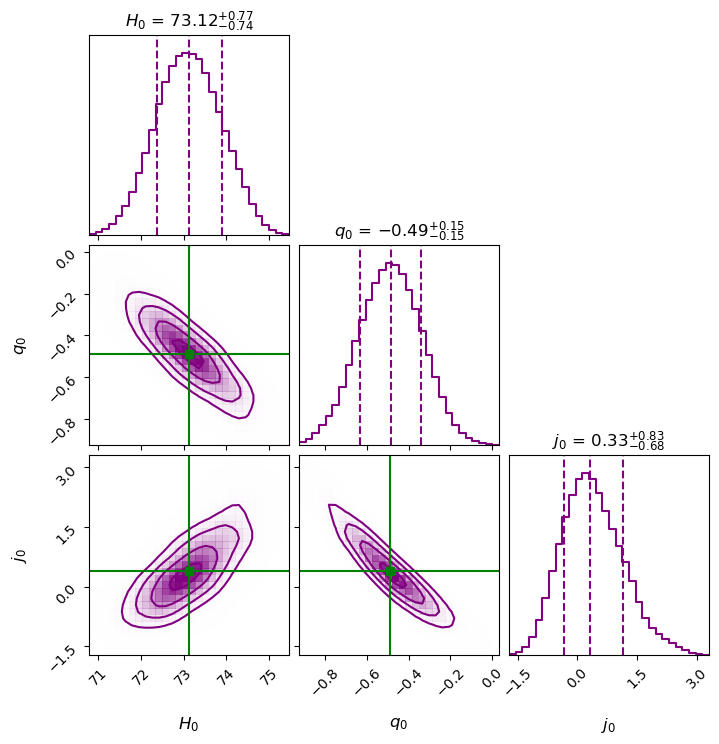

In [297]:
#plt.hist(H0_chain, bins = 60, color = "turquoise", edgecolor = "darkcyan", alpha = 0.75)
#plt.hist(q0_chain, bins = 60, color = "purple", edgecolor = "rebeccapurple", alpha = 0.75)
#plt.hist(j0_chain, bins = 60, color = "tomato", edgecolor = "brown", alpha = 0.75)

ma = statistics.mean(H0_chain)
sda = statistics.stdev(H0_chain)

mb = statistics.mean(q0_chain)
sdb = statistics.stdev(q0_chain)

ms = statistics.mean(j0_chain)
sds = statistics.stdev(j0_chain)

print("mean of H0 =", ma, "_", "standard deviation of H0 =", sda)
print("mean of q0 =", mb, "_", "standard deviation of q0 =", sdb)
print("mean of j0 =", ms, "_", "standard deviation of j0 =", sds)

#plt.axvline(ma , color = "k", linestyle = "dashed")
#plt.axvline(ma + sda , color = "firebrick", linestyle = "dashed")
#plt.axvline(ma - sda , color = "firebrick", linestyle = "dashed")

#plt.axvline(mb , color = "k", linestyle = "dashed")
#plt.axvline(mb + sdb , color = "blue", linestyle = "dashed")
#plt.axvline(mb - sdb , color = "blue", linestyle = "dashed")
#plt.show()

samples = np.column_stack([H0_chain,q0_chain,j0_chain])

params = [r"$H_0$", r"$q_0$", r"$j_0$"]

figure = corner.corner(samples, bins = 30, color = "purple", labels = params, 
                plot_datapoints = False, smooth1d = True, smooth = True, quantiles=[0.16, 0.5, 0.84],
                show_titles = True, label_kwargs = {"fontsize":12}, title_fmt=".2f",title_kwargs={"fontsize": 12})

axes = np.array(figure.axes).reshape((3, 3))

m = [ma, mb, ms]

for yi in range(3):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(m[xi], color="g")
        ax.axhline(m[yi], color="g")
        ax.plot(m[xi], m[yi], "sg")
        


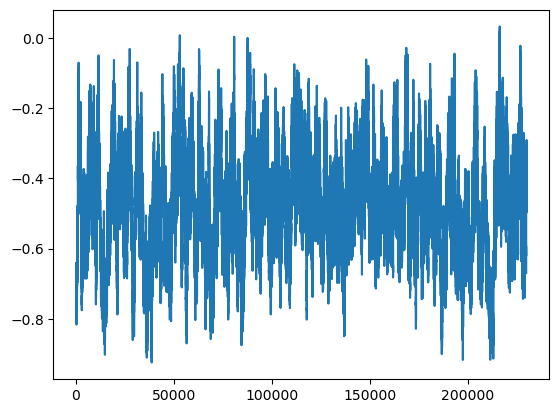

In [298]:
plt.plot(q0_chain)

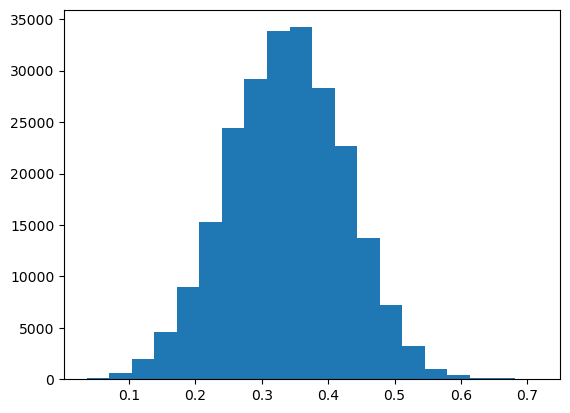

In [218]:
omega_m_samps = 2*(q0_chain + 1)/3

plt.hist(omega_m_samps, bins = 20)
plt.show()

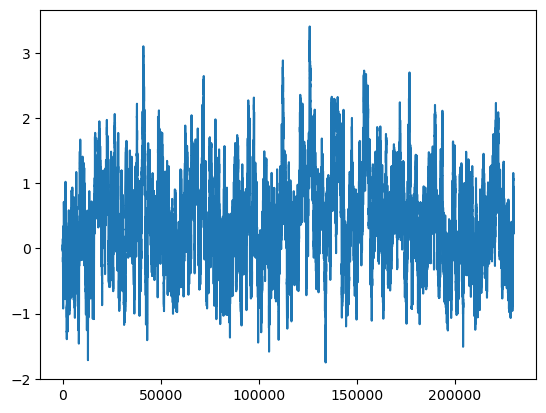

In [131]:
plt.plot(j0_chain)

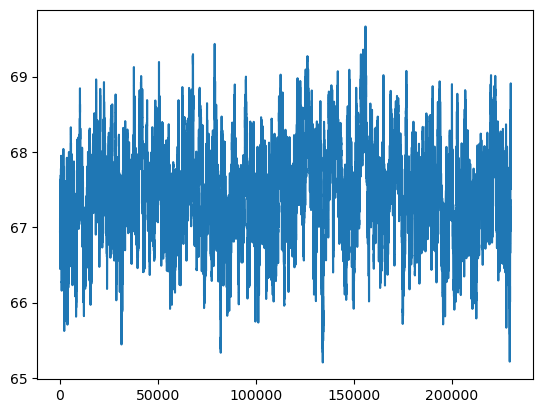

In [132]:
plt.plot(H0_chain)